# Social Media Analytics(CSE4069)

# Youtube Comments Summarizer

### 19MIA1076  - Arun Venkat S J
### 19MIA1097  - John Chacko 

# Project Flowchart

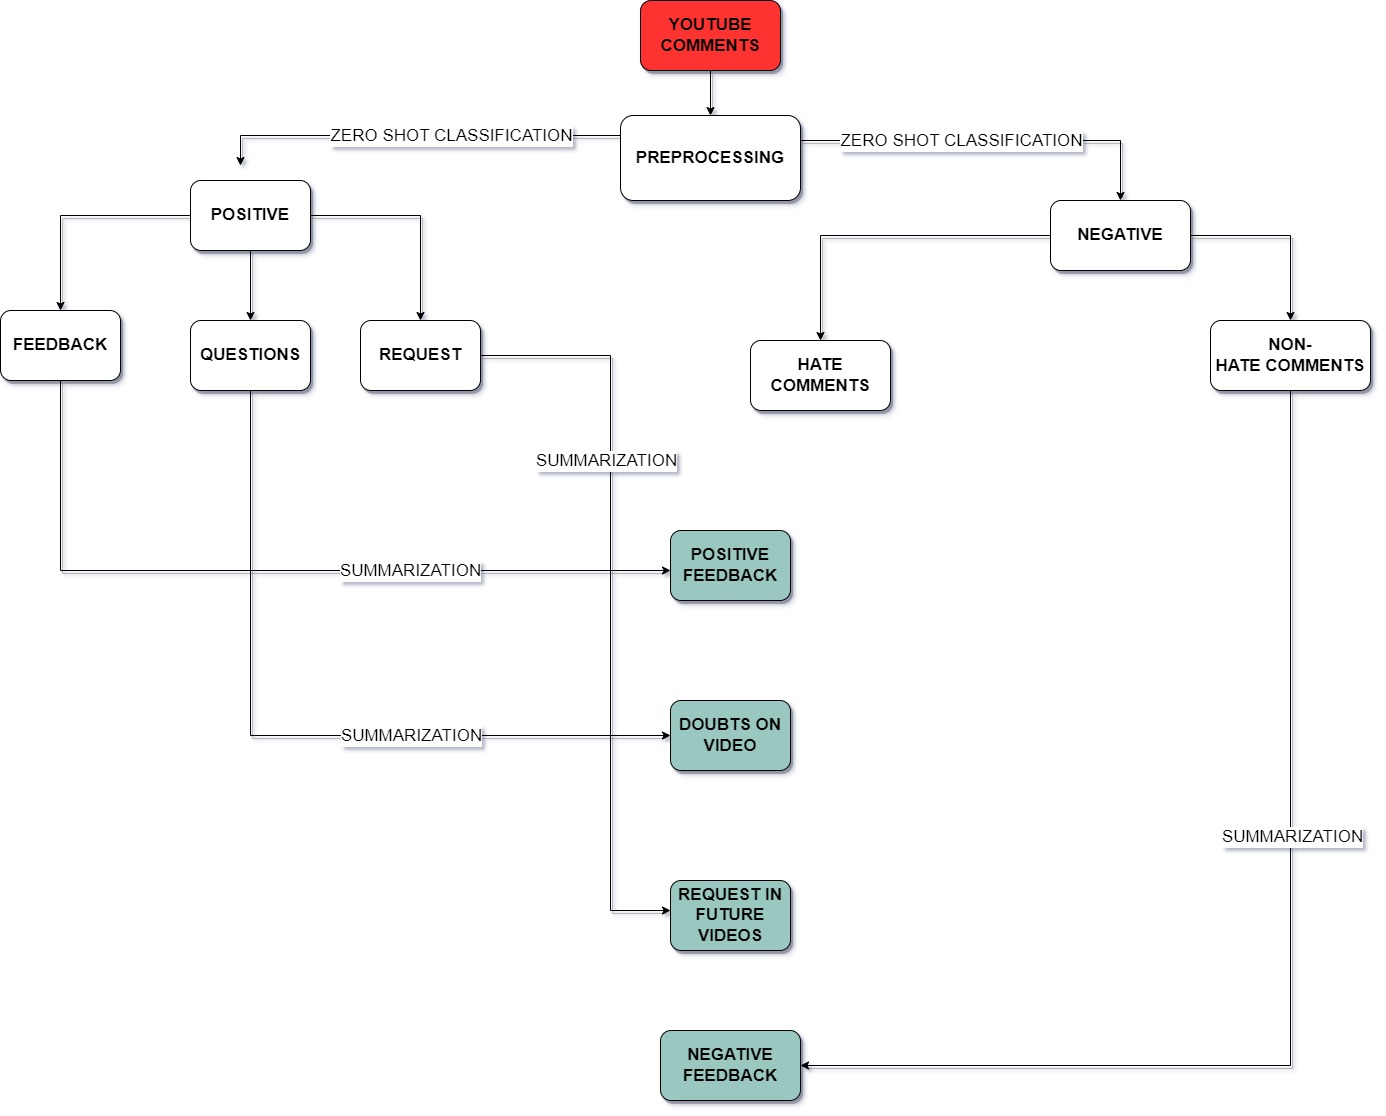

In [1]:
from IPython import display
display.Image("flowchart.jpg")

# Data Scrapping
### Youtube Comments Extracter API 

In [2]:
import os
import googleapiclient.discovery
import pandas as pd

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "ENTER_DEVELOPER_KEY"

youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=DEVELOPER_KEY)

comments = []
next_page_token = None
while True:
    request = youtube.commentThreads().list(
        part="snippet",
        maxResults=100,
        moderationStatus="published",
        order="relevance",
        textFormat="plainText",
        videoId="YgCq0Y6Mhh0",
        pageToken=next_page_token
    )
    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
        comments.append(comment)

    next_page_token = response.get('nextPageToken')

    if not next_page_token:
        break

df = pd.DataFrame({'comment': comments})
df.to_csv('comments.csv', index=False, encoding='utf-8-sig')


In [3]:
df

,comment
0,Most Python users prefer death over C++
1,"""in C++ we write everything ourselves."" ya rig..."
2,I use C++ because I wanna leak 90% of my memor...
3,Finally a C++ video for high intellectual code...
4,This guy is basically the smart version of Bel...
...,...
127,These peasants don't even use assembly.\nCan't...
128,YOOO FIRST COMMENT
129,just learn rust
130,"nah bro, i prefer Rust, c++ is ugly"


# Data Preprocessing 

In [4]:
import pandas as pd
import nltk
import re
import string
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words()

def cleaning(text):
    # check if input is not NaN
    if type(text) != str:
        return ""

    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[“”…]', '', text) 

    # removing the emojies               
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   
  
    return text

# Load the data
df = pd.read_csv("comments.csv")

# Clean the text
df["comment"] = df["comment"].apply(cleaning)

# Tokenizing and removing stopwords
df["tokens"] = df["comment"].apply(word_tokenize)
df["tokens"] = df["tokens"].apply(lambda x: [word.lower() for word in x if not word.lower() in stop_words])

print(df.head())


                                             comment  \
0              most python users prefer death over c   
1  in c we write everything ourselves ya right in...   
2  i use c because i wanna leak 90 of my memory i...   
3  finally a c video for high intellectual coders...   
4  this guy is basically the smart version of beluga   

                                              tokens  
0                     [python, users, prefer, death]  
1  [write, binary, define, objects, functions, se...  
2  [wan, leak, 90, memory, wan, memory, floor, py...  
3       [finally, video, high, intellectual, coders]  
4           [guy, basically, smart, version, beluga]  


In [5]:
df

,comment,tokens
0,most python users prefer death over c,"[python, users, prefer, death]"
1,in c we write everything ourselves ya right in...,"[write, binary, define, objects, functions, se..."
2,i use c because i wanna leak 90 of my memory i...,"[wan, leak, 90, memory, wan, memory, floor, py..."
3,finally a c video for high intellectual coders...,"[finally, video, high, intellectual, coders]"
4,this guy is basically the smart version of beluga,"[guy, basically, smart, version, beluga]"
...,...,...
127,these peasants dont even use assemblycant even...,"[peasants, assemblycant, addressing, modes, de..."
128,yooo first comment,"[yooo, comment]"
129,just learn rust,"[learn, rust]"
130,nah bro i prefer rust c is ugly,"[prefer, rust, ugly]"


In [6]:
dt = df['comment']
dt

0                  most python users prefer death over c
1      in c we write everything ourselves ya right in...
2      i use c because i wanna leak 90 of my memory i...
3      finally a c video for high intellectual coders...
4      this guy is basically the smart version of beluga
                             ...                        
127    these peasants dont even use assemblycant even...
128                                   yooo first comment
129                                      just learn rust
130                      nah bro i prefer rust c is ugly
131                                       c my favourite
Name: comment, Length: 132, dtype: object

In [7]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\sjaru\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


# Zero Shot classification
#### facebook/bart-large-mnli

In [8]:
import torch
import torchvision
import pandas as pd

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

# Define zero-shot classifier pipeline
classifier = pipeline("zero-shot-classification")

# Load text data
sequence = list(dt)
sequence[:5]

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


['most python users prefer death over c',
 'in c we write everything ourselves ya right in binary we define everything ourselves we dont got no objects functions or any semblance of code repeatability beyond copy and paste',
 'i use c because i wanna leak 90 of my memory i wanna see the memory all over on my floor can your python do that didnt think so',
 'finally a c video for high intellectual coders like myself',
 'this guy is basically the smart version of beluga']

In [9]:
# Classify text as positive or negative
candidate_labels = ['positive', 'negative']
classified = classifier(sequence[1:50], candidate_labels)
df_new = pd.DataFrame(classified)

# Extract positive and negative text
n = df_new.shape[0]
for x in range(0, n):
    df_new['labels'][x] = df_new['labels'][x][0]

pos = df_new.loc[df_new['labels'] == 'positive']
neg = df_new.loc[df_new['labels'] == 'negative']

# Positive

In [10]:
pos

,sequence,labels,scores
3,this guy is basically the smart version of beluga,positive,"[0.8575624227523804, 0.14243753254413605]"
5,i found your channel yesterday and binged all ...,positive,"[0.9655965566635132, 0.03440341725945473]"
7,important thing is that you should start by le...,positive,"[0.744079053401947, 0.255920946598053]"
10,i’m starting to learn programming and while no...,positive,"[0.6961602568626404, 0.303839772939682]"
11,c is not always the best you just need to choo...,positive,"[0.8222324252128601, 0.1777675449848175]"
13,boy am i glad i started with c as y first lang...,positive,"[0.8953624367713928, 0.10463760793209076]"
20,i just realized shregory is the future of chat...,positive,"[0.8786719441413879, 0.12132802605628967]"
22,c pro here and yes it’s the best language wait...,positive,"[0.9969165325164795, 0.003083456540480256]"
23,shregory helping the stack exchange community ...,positive,"[0.9508273005485535, 0.04917272925376892]"
24,ive never felt so represented as a c developer,positive,"[0.9873298406600952, 0.012670137919485569]"


In [11]:
# Classify positive text as doubt, request, or statement
ns = pos.sequence.values
ns = list(ns)

candidate_labels = ['doubt', 'request', 'statement']
a = classifier(ns, candidate_labels)
pos_new = pd.DataFrame(a)
pos_new.to_csv('sample.csv')

# Extract doubt, request, and statement text
pos_new = pos_new.drop('scores', axis=1)
m = pos_new.shape[0]
for x in range(0, m):
    pos_new['labels'][x] = pos_new['labels'][x][0]

statement = pos_new.loc[pos_new['labels'] == 'statement']
req = pos_new.loc[pos_new['labels'] == 'request']
ques = pos_new.loc[pos_new['labels'] == 'doubt']

stat = statement['sequence']
reqq = req['sequence']
quess = ques['sequence']

sss = ''
for x in stat:
    sss += x + '.'

ss = ''
for x in reqq:
    ss += x + '.'

s = ''
for x in quess:
    s += x + '.'

In [12]:
# Print summaries
print("\nStatements:")
print(sss)
print("\nRequests:")
print(ss)
print("\nDoubts:")
print(s)


Statements:
this guy is basically the smart version of beluga.i found your channel yesterday and binged all your billy videos so glad to see you upload regularly lol.important thing is that you should start by learning c so you know what c actually does for you.i just realized shregory is the future of chatgpt .ive never felt so represented as a c developer.i love how this is 100 true.

Requests:
c pro here and yes it’s the best language wait till billy finds out about lvalues rvalues xvlaues rvalue ref lvalue ref move semantics etc.shregory helping the stack exchange community lmao.man  keep the legendary work .i write in assembly trynna do a 100 completionist run.

Doubts:
i’m starting to learn programming and while not a lot of this video made sense to me i think i get the overall message in that c is much more difficult than python but worth it once you understand it.c is not always the best you just need to choose a language that meets your needsprogramming language is just a too

# Negative

In [13]:
neg

,sequence,labels,scores
0,in c we write everything ourselves ya right in...,negative,"[0.7640929818153381, 0.23590698838233948]"
1,i use c because i wanna leak 90 of my memory i...,negative,"[0.9531291127204895, 0.04687090218067169]"
2,finally a c video for high intellectual coders...,negative,"[0.7648480534553528, 0.2351519614458084]"
4,damn he went straight for the qt framework as ...,negative,"[0.9761084914207458, 0.023891545832157135]"
6,i feel just so slightly offended as a c developer,negative,"[0.9900036454200745, 0.009996306151151657]"
8,maybe i start with cthen some clife could be a...,negative,"[0.9749431610107422, 0.025056827813386917]"
9,the most obnoxious part of c is making your ow...,negative,"[0.9904475808143616, 0.009552400559186935]"
12,this just made me realize the world of pain im...,negative,"[0.9489305019378662, 0.05106949806213379]"
14,as someone who has coded in c i can confirm th...,negative,"[0.9302869439125061, 0.06971307843923569]"
15,i wanna see billy learn solid or something mor...,negative,"[0.503246009349823, 0.4967540204524994]"


In [14]:
# Classify negative text as hate or not hate
ns = neg.sequence.values
ns = list(ns)

candidate_labels = ['hate', 'not hate']
a = classifier(ns, candidate_labels)
neg_new = pd.DataFrame(a)

# Extract hate and not hate text
neg_new = neg_new.drop('scores', axis=1)
m = neg_new.shape[0]
for x in range(0, m):
    neg_new['labels'][x] = neg_new['labels'][x][0]

hate = neg_new.loc[neg_new['labels'] == 'hate']
nothate = neg_new.loc[neg_new['labels'] == 'not hate']

nh = nothate['sequence']
negs = neg['sequence'].astype(str)

ssss = ''
for x in nh:
    ssss += x + '.'

negss = ''
for x in negs:
    negss += x + '.'

In [15]:
print("\nNot hate summary:")
print(ssss)
print("\nHate summary:")
print(negss)


Not hate summary:
in c we write everything ourselves ya right in binary we define everything ourselves we dont got no objects functions or any semblance of code repeatability beyond copy and paste.finally a c video for high intellectual coders like myself.damn he went straight for the qt framework as his first c flex generally segfaults are easy to track if you have access to the debugger take the stack back to the last viewable frame then check out which of your pointers is fucked in many cases fucked just means  0 lol.maybe i start with cthen some clife could be a dream life could be a dreaaaaam.this just made me realize the world of pain im going into choosing c as my first.as someone who has coded in c i can confirm that our biggest fear is segmentation fault.i wanna see billy learn solid or something more abstract thats the fun bits.120 few times youll have to deal with pointer notation you can lose performance by using   can make references of your pointers in most cases and lea

# Visualizations 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 **Distribution of positive and Negative comments in the scrapped Youtube comments**

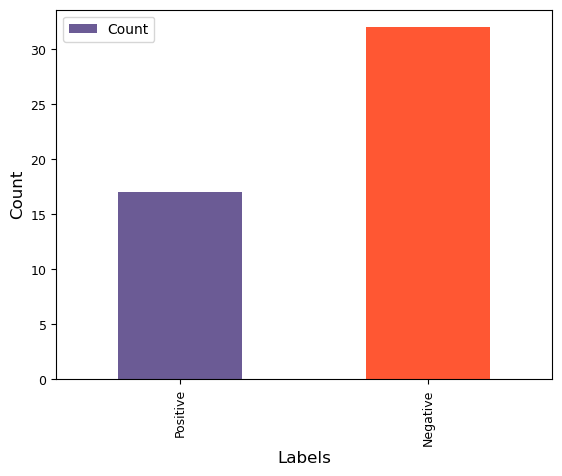

In [17]:
p = pos['labels'].count()
n = neg['labels'].count()

# Create a DataFrame with the label counts
df = pd.DataFrame({'Labels': ['Positive', 'Negative'], 'Count': [p, n]})

# Define a list of distinct colors
colors = ['#6B5B95', '#FF5733']

# Create a bar graph with distinct colors for each label
bargraph = df.plot.bar(x='Labels', y='Count', color=colors, fontsize=9)

# Set the x-axis label font size
bargraph.set_xlabel('Labels', fontsize=12)

# Set the y-axis label
bargraph.set_ylabel('Count', fontsize=12)

# Display the plot
plt.show()


 **Distribution of Doubt, Request and statement type of comments in the scrapped positive Youtube comments**

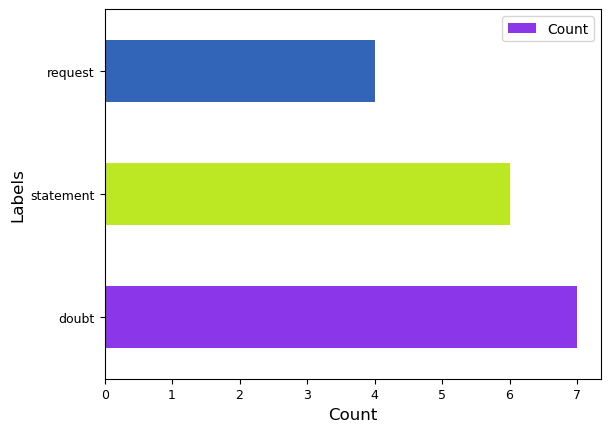

In [18]:
# Get the value counts of the 'labels' column in pos_new DataFrame
value_counts = pos_new['labels'].value_counts()

# Create a DataFrame from the value counts
df = pd.DataFrame({'Labels': value_counts.index, 'Count': value_counts.values})

# Define a list of distinct colors with length equal to number of labels
colors = ['#'+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
          for i in range(len(df))]

# Create a horizontal bar graph with distinct colors for each label
bargraph = df.plot.barh(x='Labels', y='Count', color=colors, fontsize=9)

# Set the x-axis label font size
bargraph.set_xlabel('Count', fontsize=12)

# Set the y-axis label
bargraph.set_ylabel('Labels', fontsize=12)

# Display the plot
plt.show()


 **Distribution of hate and not hate comments in the scrapped negative Youtube comments**

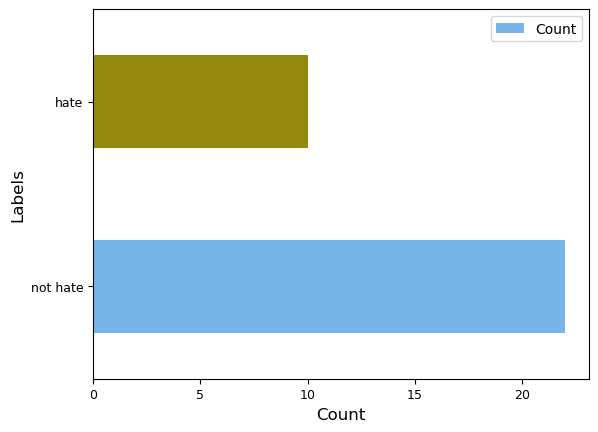

In [19]:
# Get the value counts of the 'labels' column in neg_new DataFrame
value_counts = neg_new['labels'].value_counts()

# Create a DataFrame from the value counts
df = pd.DataFrame({'Labels': value_counts.index, 'Count': value_counts.values})

# Define a list of distinct colors with length equal to number of labels
colors = ['#'+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
          for i in range(len(df))]

# Create a horizontal bar graph with distinct colors for each label
bargraph = df.plot.barh(x='Labels', y='Count', color=colors, fontsize=9)

# Set the x-axis label font size
bargraph.set_xlabel('Count', fontsize=12)

# Set the y-axis label
bargraph.set_ylabel('Labels', fontsize=12)

# Display the plot
plt.show()


# Summarizer

In [20]:
# Generate summaries for each category
from summarizer import Summarizer
model = Summarizer()
summaries = {}

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 1. Extractive Summarization

In [21]:
ex1_result = model(s[:1000], min_length=10, max_length=1024,num_sentences=3)
full1 = ''.join(ex1_result)

ex2_result = model(ss[:1000], min_length=10, max_length=1024,num_sentences=3)
full2 = ''.join(ex2_result)

ex3_result = model(sss[:1000], min_length=10, max_length=1024,num_sentences=3)
full3 = ''.join(ex3_result)

ex4_result = model(ssss[:1000], min_length=10, max_length=1024,num_sentences=3)
full4 = ''.join(ex4_result)

ex5_result = model(negss[:1000], min_length=10, max_length=1024,num_sentences=3)
full5 = ''.join(ex5_result)

In [22]:
# Print summaries
print("\nDoubts summary:")
print(full1)

print("\nRequests summary:")
print(full2)

print("\nStatements summary:")
print(full3)

print("\nNot hate summary:")
print(full4)

print("\nHate summary:")
print(full5)


Doubts summary:
i’m starting to learn programming and while not a lot of this video made sense to me i think i get the overall message in that c is much more difficult than python but worth it once you understand it.c is not always the best you just need to choose a language that meets your needsprogramming language is just a toolin my case c is my primary language because i study game software engineeringunmanaged language like c is an excellent tool for studying computer scienceyour capability of solving issues improves if you get used to lowlevel concepts like pointers indirection etcstudying lowlevel stuff will give you a deep understanding of computer hardware there are so many things you can do with your computer if you know how to utilize it efficiently and correctly.boy am i glad i started with c as y first language learning python after that was an actual walk in the park.tbh c 17 and above has many functions and abstractions included in modern languages.actually imo cpp devs

### 2. Abstractive Summarization

In [23]:
# Load summarization model
summarizer = pipeline("summarization")

# Generate summaries for different text categories
s_summary = summarizer(s[:3000],min_length=5, max_length=1024,do_sample=False)[0]['summary_text']

ss_summary = summarizer(ss[:3000],min_length=5,max_length=1024,  do_sample=False)[0]['summary_text']

sss_summary = summarizer(sss[:3000],min_length=5, max_length=1024,do_sample=False)[0]['summary_text']

nh_summary = summarizer(ssss[:3000], min_length=5, max_length=1024,  do_sample=False)[0]['summary_text']

neg_summary = summarizer(negss[:3000], min_length=5, max_length=1024,  do_sample=False)[0]['summary_text']

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your max_length is set to 1024, but you input_length is only 280. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=140)
Your max_length is set to 1024, but you input_length is only 72. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 1024, but you input_length is only 87. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 1024, but you input_length is only 533. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=266)
Your max_length is set to 1024, but you input_length is only 739. You might consider decreasing max_length manually, e.g. summarizer('...', m

In [24]:
# Print summaries
print("\nDoubts summary:")
print(s_summary)

print("\nRequests summary:")
print(ss_summary)

print("\nStatements summary:")
print(sss_summary)

print("\nNot hate summary:")
print(nh_summary)

print("\nHate summary:")
print(neg_summary)


Doubts summary:
 i'm starting to learn programming and while not a lot of this video made sense to me i think i get the overall message in that c is much more difficult than python but worth it once you understand it .

Requests summary:
 Shregory helping the stack exchange community . Keep the legendary work of assembly .

Statements summary:
 i just realized shregory is the future of chatgpt .ive never felt so represented as a c developer. this guy is basically the smart version of beluga .

Not hate summary:
 C is actually the best programming language . Segmentation fault is the language's biggest fear .

Hate summary:
 c is actually the best programming language . Segmentation fault with a side of pain is pretty accurate . The most obnoxious part of c is making your own templates . Big inheritance trees are also annoying .
